# Deterministic vs Stochastic estimator comparison on runtime logs

This notebook will focus on comparing deterministic to stochastic thresholding in terms of performane. For the stochastic case, we'll consider the *Straight-Through v1* and *Slope-Annealing (rate=0.1)* estimators, since we saw that those two performed the best. For a fair comparison we'll examine only the vanilla (i.e. fully-trained) deterministic estimator.

We'll use the same experimental procedure as in the previous notebooks:


> Runtime logs are meant to study a model's **convergence**, i.e. *how many epochs does it take for a model to converge?*, *does it experience heavy oscillations during training?*, etc. They **aren't** meant to examine the model's generalization. There are two types of runtime logs:
> 
> - **epoch** logs are the ones that are recorded **once per epoch** (usually at the end of the epoch), e.g. validation metrics.
> - **batch** logs are the ones that are recorded **once per batch** (i.e. once per model update), e.g. the model's loss.
> 
> While it is possible to examine the logs in other ways, the scope of this study involves examining the **least** amount of information that the models require to **adequately** classify. Thus we'll follow the following procedure:
> 
> 1. For each model that we want to examine, first we'll check its **validation accuracy**. Only models with sufficiently high validation accuracy, comared to the baseline, will be examined further.
> 2. They we'll check the model's **percentage of pixels hidden**. As we said we are interested in finding the least amount of information that the models require, so we'll keep the models that hide large percentage of pixels.
> 3. After filtering the models by these two conditions, we'll examine things such as the convergence speed and the stability of the model.

In [1]:
import sys
sys.path.append('..')

from utils.plotting import *

%matplotlib inline

## Load the models and the baseline 

Load logs (epoch and batch) for all three model families, as well as the baseline.

In [2]:
# Baseline
baseline_loc = '../results/cifar10/seeker/default/baseline.txt'
with open(baseline_loc) as f:
    baseline = float(f.read())
print('Baseline accuracy: {:.2f}%'.format(baseline * 100))

# Deterministic
experiment_dir = '../logs/cifar10/hns/deterministic/full_training_10/'
det_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
det_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

# ST
experiment_dir = '../logs/cifar10/hns/stochastic/st1/full_training_10/'
st1_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
st1_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

# SA-0.1
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_0.1/full_training_10/'
sa_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
sa_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

W0826 17:06:55.211179 140665267545856 deprecation.py:323] From /home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Baseline accuracy: 65.37%


## 1. Epoch logs

> How many models of each family managed to get score a decent* accuracy?  
> \* by decent we mean at least 90% of the baseline

In [3]:
det_batch_logs = filter_logs_on_val_acc(det_epoch_logs, det_batch_logs, baseline)
det_epoch_logs = filter_logs_on_val_acc(det_epoch_logs, det_batch_logs, baseline, return_epoch=True)
st1_batch_logs = filter_logs_on_val_acc(st1_epoch_logs, st1_batch_logs, baseline)
st1_epoch_logs = filter_logs_on_val_acc(st1_epoch_logs, st1_batch_logs, baseline, return_epoch=True)
sa_batch_logs = filter_logs_on_val_acc(sa_epoch_logs, sa_batch_logs, baseline)
sa_epoch_logs = filter_logs_on_val_acc(sa_epoch_logs, sa_batch_logs, baseline, return_epoch=True)

print('Deterministic:    ', len(det_batch_logs))
print('Straight-Through: ', len(st1_batch_logs))
print('Slope-Annealing:  ', len(sa_batch_logs))

Deterministic:     4
Straight-Through:  9
Slope-Annealing:   10


So, while multiple deterministic models collapsed, no stochastic model did (just one scores slightly below the baseline). 

> What is the mean final accuracy of those models?  
> i.e. for the models that score at least 90% of the baseline, what is their mean final accuracy

In [4]:
print('Deterministic:    ', np.mean([log['Validation accuracy'].iloc[-1] for log in det_epoch_logs]))
print('Straight-Through: ', np.mean([log['Validation accuracy'].iloc[-1] for log in st1_epoch_logs]))
print('Slope-Annealing:  ', np.mean([log['Validation accuracy'].iloc[-1] for log in sa_epoch_logs]))

Deterministic:     0.6120849549770355
Straight-Through:  0.6152975426779853
Slope-Annealing:   0.620361453294754


Even if we filter out the collapsed and underperforming models, the stochastic ones still outperform the deterministic!

> What about peak performance?

In [5]:
print('Deterministic:    ', np.max([log['Validation accuracy'].iloc[-1] for log in det_epoch_logs]))
print('Straight-Through: ', np.max([log['Validation accuracy'].iloc[-1] for log in st1_epoch_logs]))
print('Slope-Annealing:  ', np.max([log['Validation accuracy'].iloc[-1] for log in sa_epoch_logs]))

Deterministic:     0.631152331829071
Straight-Through:  0.636570394039154
Slope-Annealing:   0.6380537748336792


Even thought the results are closer here, the deterministic models perform worse than the stochastic ones.

> How many epochs did they nead (in average) to converge?

In [6]:
def average_epochs(logs):
    return np.mean([log['Validation accuracy'].apply(
        lambda x: np.nan if x == log['Validation accuracy'].iloc[-1] else x).count() for log in logs])

print('Deterministic:    ', average_epochs(det_epoch_logs))
print('Straight-Through: ', average_epochs(st1_epoch_logs))
print('Slope-Annealing:  ', average_epochs(sa_epoch_logs))

Deterministic:     36.75
Straight-Through:  24.22222222222222
Slope-Annealing:   35.8


Again, it is evident that the deterministic models are the slowest to converge (though it is close to the slope-annealing estimator). The fastest models appear to be, by far, the ST ones.

## 2. Batch logs

> Out of the models that performed well on classification, how many models managed to generate a decent* masking percentage?  
> \* over 90% of the pixels are masked

In [7]:
det_batch_logs = filter_logs_on_pix_hidden(det_batch_logs)
st1_batch_logs = filter_logs_on_pix_hidden(st1_batch_logs)
sa_batch_logs = filter_logs_on_pix_hidden(sa_batch_logs)

print('Deterministic:    ', len(det_batch_logs))
print('Straight-Through: ', len(st1_batch_logs))
print('Slope-Annealing:  ', len(sa_batch_logs))

Deterministic:     3
Straight-Through:  4
Slope-Annealing:   4


Not much difference here, however if you recall from the stochastic estimator comparison notebook, the stochastic estimators managed to find sub-optimal solutions instead of fully collapsing, which is a plus.

> Out of these, what is the average percentage of hidden pixels?

In [8]:
print('Deterministic:    ', np.mean([log['percentage hidden'].iloc[-1] for log in det_batch_logs]))
print('Straight-Through: ', np.mean([log['percentage hidden'].iloc[-1] for log in st1_batch_logs]))
print('Slope-Annealing:  ', np.mean([log['percentage hidden'].iloc[-1] for log in sa_batch_logs]))

Deterministic:     96.01615905761719
Straight-Through:  97.68606185913086
Slope-Annealing:   97.12706565856934


Here too, stochastic estimators converge to better overall solutions.

> What is the highest percentage of hidden pixels?

In [9]:
print('Deterministic:    ', np.max([log['percentage hidden'].iloc[-1] for log in det_batch_logs]))
print('Straight-Through: ', np.max([log['percentage hidden'].iloc[-1] for log in st1_batch_logs]))
print('Slope-Annealing:  ', np.max([log['percentage hidden'].iloc[-1] for log in sa_batch_logs]))

Deterministic:     97.60135650634766
Straight-Through:  99.23759460449219
Slope-Annealing:   98.03825378417969


The highest two models are the stochastic ones, again. 

> How many steps did it take these models, on average, to converge?

In [10]:
def average_iterations(logs):
    return np.mean([log[log['loss regulator'] < 0.15].index.min() for log in logs])

print('Deterministic:    ', average_iterations(det_batch_logs))
print('Straight-Through: ', average_iterations(st1_batch_logs))
print('Slope-Annealing:  ', average_iterations(sa_batch_logs))

Deterministic:     720.0
Straight-Through:  1043.25
Slope-Annealing:   861.25


The deterministic models that converged to the decent solutions were actually faster than those trained with stochastic estimators.

In [11]:
def fewest_iterations(logs):
    return np.min([log[log['loss regulator'] < 0.15].index.min() for log in logs])

print('Deterministic:    ', fewest_iterations(det_batch_logs))
print('Straight-Through: ', fewest_iterations(st1_batch_logs))
print('Slope-Annealing:  ', fewest_iterations(sa_batch_logs))

Deterministic:     589
Straight-Through:  849
Slope-Annealing:   620


Again the fastest model was a deterministic one.

Let's see this visually. The best model was identified empirically by using `plot_all_logs(xxx_batch_logs, column_name='percentage hidden')`.

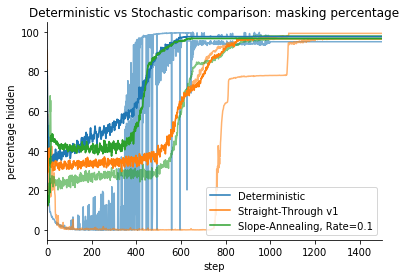

In [12]:
fancy_plot(det_batch_logs, 'percentage hidden', 0, color='C0', label='Deterministic')
fancy_plot(st1_batch_logs, 'percentage hidden', 0, color='C1', label='Straight-Through v1')
fancy_plot(sa_batch_logs, 'percentage hidden', 3, color='C2', label='Slope-Annealing, Rate=0.1')

plt.title('Deterministic vs Stochastic comparison: masking percentage')
plt.legend(loc='lower right')
plt.xlim([0, 1500])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

It is evident that, while the deterministic models converge faster, the stochastic ones are both more stable and converge to better overall solutions.

Now, we'll check the total loss of the models (this is one of the most reliable metrics as it combines both classification and masking performance).

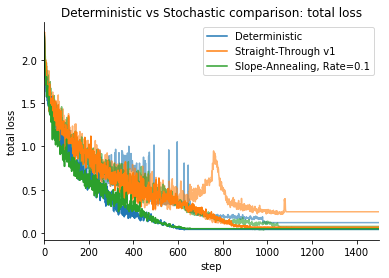

In [13]:
fancy_plot(det_batch_logs, 'total loss', 0, color='C0', label='Deterministic')
fancy_plot(st1_batch_logs, 'total loss', 0, color='C1', label='Straight-Through v1')
fancy_plot(sa_batch_logs, 'total loss', 3, color='C2', label='Slope-Annealing, Rate=0.1')

plt.title('Deterministic vs Stochastic comparison: total loss')
plt.legend(loc='upper right')
plt.xlim([0, 1500])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Finally, the loss regulator (i.e. alpha) provides a look into the convergence of the models.

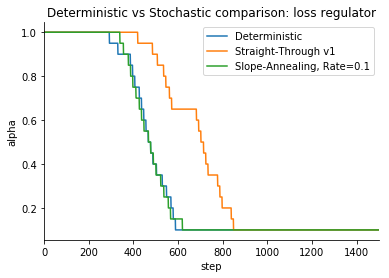

In [14]:
plt.plot(det_batch_logs[0]['step'], det_batch_logs[0]['loss regulator'], label='Deterministic')
plt.plot(st1_batch_logs[0]['step'], st1_batch_logs[0]['loss regulator'], label='Straight-Through v1')
plt.plot(sa_batch_logs[3]['step'], sa_batch_logs[3]['loss regulator'], label='Slope-Annealing, Rate=0.1')

plt.xlim([0, 1500])
plt.title('Deterministic vs Stochastic comparison: loss regulator')
plt.ylabel('alpha')
plt.xlabel('step')
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Interestingly, the fastest deterministic model isn't much faster than the fastest slope-annlealing one.

## Discussion

### Definitions

As defined in previous notebooks:

> - There are two factors that come into play: **performance** (i.e. how high the accuracy was for a certain model) and **variance** (i.e. if we repeat the experiment how likely are we to expect the same performance.)
> - There are two types of variance we observed here. Variance of a single model for different values of alpha and the variance for training the same model more than once. When we use the term *variance* we'll refer to **both** types.
> - We want a model to have **high performance** (i.e. high accuracy) and **low variance** (i.e. few fluctuations in performance).
> - The performance of a trained seeker, on its own, will be referred to as the **baseline** performance. Obviously, because we are hiding information, the models aren't able to surpass this performance. It will serve as the upper limit for our experiments.
> - There are two extreme states that the model can get *locked* into, which provide suboptimal solutions:
> 
>     - The model doesn't hide anything, but classifies correctly.
>     - The model hides everything, but classifies randomly.
> 
>     These states will be referred to as **collapses**.

### Observations

- Stochastic models **collapsed fewer times** than deterministic ones.
- Stochastic models **achieved a much higher average and peak accuracy** than deterministic ones.
- Given the conditions we set for a successful training (i.e. at least 90% of baseline validation accuracy and 90% masking percentage), **stochastic models produced valid solutions slightly more frequently** than deterministic ones (i.e. 40% for stochastic 30% for deterministic).  
- Stochastic models managed a **slightly higher average and peak masking percentage**.
- Stochastic model were **more stable** and had a **lower variance** than deterministic ones.
- Stochastic models required fewer epochs in general to converge. However out of the models that did converge to valid solutions, **deterministic models converged faster**. 
- Out of the two stochastic estimators, slope annealing had a slightly better performance on classification, while straight-through achieved a slightly better masking percentage.

### Interpretations

Stochastic models, due to their nature, have a chance of masking any pixel on the image. This behaviour favours **exploration** during training, which leads to **more stable** models, **less prone to collapse**. There is little to none chance of a model converging to a solution where it either masks the entire image or none at all. Furthermore, they provide **better** solutions for both **masking** and **classification**.

Deterministic models, on the other hand, favour **exploitation**. This causes the models to **converge faster**, but generally score slightly lower, are less stable, have a higher variance and are more prone to collapse.

### Conclusions

- Stochastic models appear to be better than deterministic ones, mainly due to their **lower variance**.
- Out of the stochastic estimators, the *Straight-Through v1* and the *Slope-Annealing (Rate=0.1)* are the best, with little evidence to prefer one over the other. 